In [1]:
#hide
#!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *

In [3]:
!!nvidia-smi
#help(learn.mldel)
#doc(learn.model)??d

['Sun Sep 27 17:12:43 2020       ',
 '+-----------------------------------------------------------------------------+',
 '| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |',
 '|-------------------------------+----------------------+----------------------+',
 '| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |',
 '| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |',
 '|===============================+======================+======================|',
 '|   0  Quadro RTX 6000     On   | 00000000:00:06.0 Off |                    0 |',
 '| N/A   51C    P0    71W / 250W |   3748MiB / 22698MiB |      0%      Default |',
 '+-------------------------------+----------------------+----------------------+',
 '                                                                               ',
 '+-----------------------------------------------------------------------------+',
 '| Processes:                          

In [4]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

In [5]:
#hide
Path.BASE_PATH = path

In [6]:
path.ls()

(#2) [Path('images'),Path('annotations')]

In [7]:
(path/"images").ls()

(#7393) [Path('images/Siamese_87.jpg'),Path('images/chihuahua_126.jpg'),Path('images/german_shorthaired_97.jpg'),Path('images/Bombay_157.jpg'),Path('images/Bengal_12.jpg'),Path('images/japanese_chin_116.jpg'),Path('images/havanese_109.jpg'),Path('images/scottish_terrier_122.jpg'),Path('images/yorkshire_terrier_146.jpg'),Path('images/boxer_176.jpg')...]

In [8]:
fname = (path/"images").ls()[0]

In [9]:
re.findall(r'(.+)_\d+.jpg$', fname.name)

['Siamese']

In [10]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

## Presizing

이미지가 GPU에 전달 될 텐서로 정렬 될 수 있도록 동일한 크기를 가져야합니다. 또한 우리가 수행하는 고유 한 증가 계산의 수를 최소화하려고합니다. 성능 요구 사항은 가능한 경우 augmentation transforms(증강 변환)을 더 적은 변환으로 구성하고 (계산 수와 손실 연산 수를 줄이기 위해) 이미지를 균일 한 크기로 변환 (GPU에서보다 효율적인 처리를 위해)해야한다고 제안합니다.

문제는 증가 된 크기로 크기를 조정 한 후 수행 할 경우 다양한 공통 데이터 증가 변환이 허위 빈 영역을 도입하거나 데이터를 저하 시키거나 둘 다를 수행 할 수 있다는 것입니다. 예를 들어 이미지를 45도 회전하면 새 경계의 모서리 영역이 비어 있으므로 모델에 아무것도 가르치지 않습니다. 많은 회전 및 확대 / 축소 작업에서 픽셀을 만들기 위해 interpolating(보간)이 필요합니다. 이러한 보간 된 픽셀은 원본 이미지 데이터에서 파생되지만 여전히 품질이 낮습니다.

이러한 문제를 해결하기 위해 presizing(사전 크기 조정)은 << presizing(사전 크기 조정) >>에 표시된 두 가지 전략을 채택합니다.

1. 이미지의 크기를 상대적으로 "큰"차원, 즉 목표 훈련 차원보다 훨씬 더 큰 차원으로 조정합니다.
1. 모든 일반적인 증가 작업 (최종 대상 크기에 대한 크기 조정 포함)을 하나로 구성하고 작업을 개별적으로 수행하고 여러 번 보간하는 대신 처리가 끝날 때 GPU에서 한 번만 결합 된 작업을 수행합니다.

첫 번째 단계 인 크기 조정은 빈 영역을 만들지 않고 내부 영역에서 추가 확대 변환을 수행 할 수 있도록 여유 여백을 가질만큼 충분히 큰 이미지를 만듭니다. 이 변형은 큰 자르기 크기를 사용하여 정사각형으로 크기를 조정하여 작동합니다. 훈련 세트에서 자르기 영역은 무작위로 선택되고 자르기 크기는 이미지의 전체 너비 또는 높이 중 작은 쪽을 포함하도록 선택됩니다.

두 번째 단계에서 GPU는 모든 데이터 증가에 사용되며 잠재적으로 파괴적인 모든 작업이 끝에서 단일 보간으로 함께 수행됩니다.

<img alt="Presizing on the training set" width="600" caption="Presizing on the training set" id="presizing" src="images/att_00060.png">

This picture shows the two steps:

1. * Crop full width or height(전체 너비 또는 높이 자르기) * :`item_tfms`에 있으므로 GPU에 복사되기 전에 각 개별 이미지에 적용됩니다. 모든 이미지가 동일한 크기인지 확인하는 데 사용됩니다. 훈련 세트에서 자르기 영역은 무작위로 선택됩니다. 유효성 검사 세트에서는 이미지의 중앙 사각형이 항상 선택됩니다.
2. * Random crop and augment(무작위 자르기 및 증가) * :`batch_tfms`에 있으므로 GPU에서 일괄 처리에 한 번에 적용되므로 빠릅니다. 검증 세트에서는 모델에 필요한 최종 크기로의 크기 조정 만 여기에서 수행됩니다. 훈련 세트에서 무작위 자르기 및 기타 확대 작업이 먼저 수행됩니다.

fastai에서이 프로세스를 구현하려면 'Resize'를 큰 크기의 항목 변환으로 사용하고 'RandomResizedCrop'을 작은 크기의 일괄 변환으로 사용합니다. 이전 섹션의 'DataBlock'호출에서했던 것처럼 'aug_transforms'함수에 'min_scale'매개 변수를 포함하면 'RandomResizedCrop'이 추가됩니다. 또는 초기`크기 조정`에`crop` (기본값) 대신`pad` 또는`squish`를 사용할 수 있습니다.

<< interpolations(보간) >>은 오른쪽에 표시된 확대, 보간, 회전 및 다시 보간 된 이미지 (다른 모든 딥 러닝 라이브러리에서 사용되는 접근 방식)와 하나의 작업으로 확대 및 회전 한 다음 왼쪽에서 한 번만 보간 (fastai 접근 방식), 여기 왼쪽에 표시됩니다.

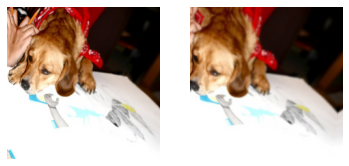

In [11]:
#hide_input
#id interpolations
#caption A comparison of fastai's data augmentation strategy (left) and the traditional approach (right).
dblock1 = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_y=parent_label,
                   item_tfms=Resize(460))
#dls1 = dblock1.dataloaders([(Path.cwd()/'images'/'grizzly.jpg')]*100, bs=8)
dls1 = dblock1.dataloaders([(path/'images'/'beagle_191.jpg')]*100, bs=8)
dls1.train.get_idxs = lambda: Inf.ones
x,y = dls1.valid.one_batch()
_,axs = subplots(1, 2)

x1 = TensorImage(x.clone())
x1 = x1.affine_coord(sz=224)
x1 = x1.rotate(draw=30, p=1.)
x1 = x1.zoom(draw=1.2, p=1.)
x1 = x1.warp(draw_x=-0.2, draw_y=0.2, p=1.)

tfms = setup_aug_tfms([Rotate(draw=30, p=1, size=224), Zoom(draw=1.2, p=1., size=224),
                       Warp(draw_x=-0.2, draw_y=0.2, p=1., size=224)])
x = Pipeline(tfms)(x)
#x.affine_coord(coord_tfm=coord_tfm, sz=size, mode=mode, pad_mode=pad_mode)
TensorImage(x[0]).show(ctx=axs[0])
TensorImage(x1[0]).show(ctx=axs[1]);

## Improving Our Model(모델 개선)

이제 모델의 학습을 개선하고 개선하기위한 다양한 기술을 살펴 보겠습니다. 그렇게하는 동안 전이 학습에 대해 조금 더 설명하고 사전 훈련 된 가중치를 깨지 않고 가능한 한 최선으로 사전 훈련 된 모델을 미세 조정하는 방법을 설명합니다.
모델을 훈련 할 때 가장 먼저 설정해야하는 것은 learning rate 입니다. 우리는 이전 장에서 가능한 한 효율적으로 훈련하는 것이 옳 아야한다는 것을 보았습니다. 그렇다면 좋은 훈련을 어떻게 선택합니까? fastai는이를 위한 도구를 제공합니다.

In [38]:
#!pip install -U pandoc nbconvedrt==5.6.1

# Image Classification

### The Learning Rate Finder

모델을 훈련 할 때 우리가 할 수있는 가장 중요한 일 중 하나는 올바른 learning rate 이 있는지 확인하는 것입니다.
learning rate 이 너무 낮 으면 모델을 훈련하는 데 많은 epochs 가 걸릴 수 있습니다.
이로 인해 시간이 낭비 될뿐만 아니라 과적 합에 문제가 있을 수 있습니다. 데이터를 완전히 통과 할 때마다 모델이 이를 기억할 수있는 기회를 주기 때문입니다.

그럼 우리의 learning rate 을 정말 높게 만들어 봅시다. 맞죠? 물론입니다. 시도해 보겠습니다.

In [65]:
learn = cnn_learner(dls, resnet34, metrics=[error_rate, accuracy])
#learn.fine_tune(1, base_lr=0.1)
learn.fine_tune(12, base_lr=0.1)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.811219,4.816168,0.470907,0.529093,00:33


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,3.424243,2.475913,0.471583,0.528417,00:38
1,1.970658,4.125483,0.608931,0.391069,00:37
2,1.778953,5.033820,0.717862,0.282138,00:37
3,3.725295,4.192646,0.917456,0.082544,00:37
4,3.591733,4.358880,0.824087,0.175913,00:40
5,3.186769,14.519431,0.772666,0.227334,00:38
6,2.648999,1.814675,0.571719,0.428281,00:40
7,2.094190,1492.908325,0.496617,0.503383,00:37
8,1.725954,42.514191,0.468877,0.531123,00:36
9,1.425681,268.879425,0.308525,0.691475,00:37


여기에 무슨 일이 있었는지 좋지 않은 것 같습니다.
optimizer 는 올바른 방향으로 갔지만 지금까지 밟아서 minimum loss 를 완전히 초과했습니다.
이를 여러 번 반복하면 더 가까워지지 않고 더 멀어집니다!

너무 높지 않고 너무 낮지도 않은 완벽한 learning rate 을 찾기 위해 어떻게해야합니까?
2015 년에 연구원 Leslie Smith (레슬리 스미스)는 * learning rate finder *라는 훌륭한 아이디어를 내놓았습니다.

그의 아이디어는 매우 작은 learning rate로 시작하는 것이 었습니다. 너무 작아서 처리하기에는 너무 크지 않을 것이라고 예상 할 수 없었습니다. 우리는 그것을 하나의 mini-batch에 사용하고, 나중에 losse 가  무엇인지 찾은 다음, learning rate 을 일정 비율로 증가시킵니다 (예 : 매번 두 배로 증가). 그런 다음 다시 미니 배치를 수행하고 losse 를 추적하고 learning rate 를 다시 두 배로 늘립니다.

그런 다음 다시 미니 배치를 수행하고 loss를 추적하고 learning rate을 다시 두 배로 늘립니다.
우리는 loss가 더 나아지는 것이 아니라 더 나빠질 때까지 이것을 계속합니다.
이것은 우리가 너무 멀리 갔다는 것을 아는 지점입니다.
그런 다음이 지점보다 약간 낮은 learning rate 을 선택합니다. 우리의 조언은 다음 중 하나를 선택하는 것입니다.

- 최소 loss 이 달성 된 지점보다 1 배 더 작음 (즉, 최소값을 10으로 나눈 값)
- loss가  분명히 감소한 마지막 지점

학습률 파인더는 곡선에서 이러한 포인트를 계산하여 도움을줍니다. 이 두 규칙은 일반적으로 거의 동일한 값을 제공합니다. 첫 번째 장에서는 fastai 라이브러리의 기본값 (1e-3)을 사용하여 learning rate 을 지정하지 않았습니다.

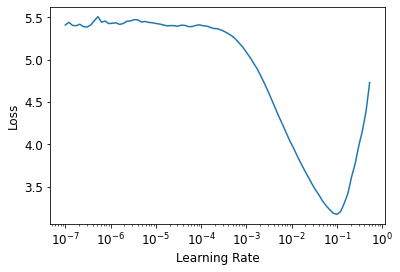

In [66]:
learn = cnn_learner(dls, resnet34, metrics=[error_rate, accuracy])
lr_min,lr_steep = learn.lr_find()

In [67]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")
print(f"Minimum/10: {lr_min:.8f}, steepest point: {lr_steep:.8f}")

Minimum/10: 1.00e-02, steepest point: 3.63e-03
Minimum/10: 0.01000000, steepest point: 0.00363078


이 플롯에서 1e-6에서 1e-3까지의 범위에서는 실제로 아무 일도 일어나지 않고 모델이 훈련되지 않는다는 것을 알 수 있습니다.
그런 다음 loss는 최소값에 도달 할 때까지 감소하기 시작했다가 다시 증가합니다.
우리는 1e-1보다 더 큰 learning rate를 원하지 않습니다. 이전과 같은 훈련을 제공하기 때문입니다 (스스로 시도 할 수 있음). 그러나 1e-1은 이미 너무 높습니다. : 이 단계에서 우리는 손실이 꾸준히 감소하는 기간 입니다.

이 학습률 도표에서 3e-3 정도의 learning rate가 적절할 것으로 보이므로 다음 중 하나를 선택해 보겠습니다.

In [68]:
learn = cnn_learner(dls, resnet34, metrics=[accuracy, error_rate])
learn.fine_tune(12, base_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.289823,0.350821,0.895129,0.104871,00:34


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.437231,0.229222,0.918133,0.081867,00:39
1,0.337272,0.342627,0.892422,0.107578,00:36
2,0.350027,0.395267,0.884980,0.115020,00:31
3,0.339811,0.521901,0.868065,0.131935,00:31
4,0.248116,0.355877,0.900541,0.099459,00:37
5,0.199430,0.368993,0.903248,0.096752,00:39
6,0.168403,0.345547,0.910014,0.089986,00:39
7,0.109880,0.333370,0.914073,0.085927,00:37
8,0.072189,0.286546,0.929635,0.070365,00:39
9,0.051363,0.262544,0.928281,0.071719,00:38


> 참고 : Logarithmic Scale(로그 척도) : learning rate finder 플롯에는 Logarithmic Scale이 있으므로 1e-3과 1e-2 사이의 중간 점이 3e-3과 4e-3 사이에 있습니다. 이것은 우리가 주로 learning rate의 정도에 관심이 있기 때문입니다.

learning rate finder(학습률 파인더)는 2015 년에야 발견되었고 신경망은 1950 년대부터 개발 중이라는 점이 흥미롭습니다. 
그 시간 동안 좋은 learning rate 을 찾는 것은 아마도 실무자에게 가장 중요하고 도전적인 문제였습니다. 
soltuon에는 고급 수학, 거대한 컴퓨팅 리소스, 방대한 데이터 세트 또는 호기심 많은 연구원이 액세스 할 수 없는 기타 모든 것이 필요하지 않습니다. 
또한 Leslie Smith는 일부 독점 실리콘 밸리 연구소의 일원이 아니었지만 해군 연구원으로 일하고있었습니다. 
이 모든 것은: 딥 러닝의 획기적인 작업에는 방대한 리소스, 엘리트 팀 또는 고급 수학적 아이디어에 대한 액세스가 절대적으로 필요하지 않습니다. 약간의 상식, 창의성 및 끈기가 필요한 작업이 아직 많이 남아 있습니다.

모델을 학습 할 수있는 좋은 학습률을 얻었으므로 사전 학습 된 모델의 가중치를 미세 조정할 수있는 방법을 살펴 보겠습니다.

### Unfreezing and Transfer Learning(고정 해제 및 전이 학습)

<<chapter_intro>> 에서 전이 학습이 작동하는 방식에 대해 간략하게 논의했습니다. 기본 아이디어는 잠재적으로 수백만 개의 데이터 포인트 (예 : ImageNet)에서 훈련 된 사전 훈련 된 모델이 다른 작업에 대해 미세 조정된다는 것입니다. 그러나 이것이 실제로 무엇을 의미합니까?

우리는 이제 convolutional neural network 이 각 쌍 사이에 비선형 활성화 함수가있는 많은 선형 계층과 맨 끝에 소프트 맥스와 같은 활성화 함수가있는 하나 이상의 final linear layers(최종 선형 계층)으로 구성된다는 것을 알고 있습니다. 최종 선형 계층은 출력 크기가 모델의 클래스 수와 같도록 충분한 열이있는 행렬을 사용합니다 (분류를 수행한다고 가정).

이 최종 선형 계층은 transfer learning(전이 학습) 설정에서 미세 조정할 때 유용하지 않을 것입니다. 원래 pretraining dataset(사전 훈련 데이터 세트)의 범주를 분류하도록 특별히 설계 되었기 때문입니다. 따라서 전이 학습을 수행 할 때 이를 제거하고 버리고 원하는 작업에 대한 정확한 출력 수를 가진 새로운 선형 레이어로 교체합니다 (이 경우 37 개의 활성화가 있음).

새로 추가 된이 선형 레이어는 완전히 무작위 가중치를 갖습니다. 따라서 미세 조정 이전의 모델은 완전히 무작위로 출력됩니다. 그러나 그것이 완전히 무작위 모델이라는 것을 의미하지는 않습니다! 마지막 레이어 이전의 모든 레이어는 일반적으로 이미지 분류 작업에 능숙하도록 신중하게 훈련되었습니다.
<< chapter_intro >>의 [Zeiler and Fergus paper] (https://arxiv.org/pdf/1311.2901.pdf) 이미지에서 보듯이 (<< img_layer1 >>부터 << img_layer4 >>까지 참조), 처음 몇 개의 레이어는 그라디언트 및 가장자리 찾기와 같은 매우 일반적인 개념을 인코딩하고 이후 레이어는 눈알과 털 찾기와 같이 여전히 우리에게 매우 유용한 개념을 인코딩합니다.
![img_layer1부터 img_layer5까지 ](./layer1_layer5.PNG)

우리는 사전 훈련 된 모델에서 일반적으로 유용한 모든 아이디어를 기억하고,이를 사용하여 특정 작업 (애완 동물 품종 분류)을 해결하고, 세부 사항에 필요한 대로만 조정할 수 있도록 우리의 특별한 임무에 모델을 훈련시키고 싶습니다.

미세 조정시 우리의 과제는 추가 된 선형 레이어의 무작위 가중치를 신중하게 사전 훈련 된 가중치와 다른 레이어를 깨지 않고 원하는 작업 (애완 동물 품종 분류)을 올바르게 달성하는 가중치로 대체하는 것입니다. 
실제로 이것을 가능하게하는 아주 간단한 트릭이 있습니다 : 옵티 마이저에게 무작위로 추가 된 최종 레이어의 가중치 만 업데이트하도록 지시하십시오. 나머지 신경망의 가중치를 전혀 변경하지 마십시오.
이를 사전 훈련 된 레이어를 *freezing* (고정 )한다 라고합니다.


사전 훈련 된 네트워크에서 모델을 생성 할 때 fastai는 사전 훈련 된 모든 계층을 자동으로 고정시킵니다. `fine_tune` 메소드를 호출하면 fastai는 두 가지 작업을 수행합니다.

- 다른 모든 레이어가 고정 된 상태에서 한 epoch 동안 무작위로 추가 된 레이어를 훈련시킵니다.
- 모든 레이어를 Unfreezes(고정 해제)하고 요청 된 Epoch 수에 대해 모두 훈련합니다.

이것은 합리적인 기본 접근 방식이지만 특정 데이터 세트에 대해 약간 다른 작업을 수행하면 더 나은 결과를 얻을 수 있습니다. 
`fine_tune` 메서드에는 동작을 변경하는 데 사용할 수있는 여러 parameters가 있지만 일부 사용자 지정 동작을 얻으려면 기본 메서드를 직접 호출하는 것이 가장 쉬울 수 있습니다.
다음 구문을 사용하여 메서드의 소스 코드를 볼 수 있습니다.:

    learn.fine_tune??

그러니 직접 수동으로 시도해 봅시다. 
우선 우리는`fit_one_cycle`을 사용하여 3 개의 epoch 동안 무작위로 추가 된 레이어를 훈련 할 것입니다. 
<< chapter_intro >>에서 언급했듯이
`fit_one_cycle`은`fine_tune`을 사용하지 않고 모델을 학습시키는 권장 방법입니다. 그 이유는 나중에 책에서; 
간단히 말해서`fit_one_cycle`이하는 일은 낮은 learning rate 로 훈련을 시작하고 훈련의 첫 번째 섹션에 대해 점차적으로 증가시킨 다음 마지막 훈련 섹션에 대해 점차적으로 다시 감소시키는 것입니다.

In [69]:
learn.fine_tune??

In [70]:
learn = cnn_learner(dls, resnet34, metrics=[accuracy, error_rate])
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.110254,0.347498,0.887010,0.112991,00:29
1,0.521288,0.282984,0.905954,0.094046,00:30
2,0.328797,0.250025,0.918133,0.081867,00:32


그런 다음 모델을 unfreeze(고정 해제) 합니다.

In [71]:
learn.unfreeze()

훈련 할 레이어가 더 많고 이미 세 epoch 동안 훈련 된 가중치가 있으므로`lr_find`를 다시 실행하면 이전에 찾은 learning rate 이 더 이상 적절하지 않습니다.

SuggestedLRs(lr_min=2.2908675418875645e-07, lr_steep=1.5848931980144698e-06)

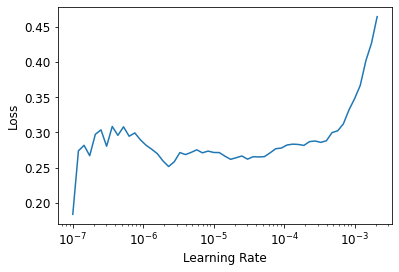

In [72]:
learn.lr_find()

그래프는 무작위 가중치가있을 때와 약간 다릅니다. 모델이 훈련 중임을 나타내는 급강하가 없습니다. 우리 모델이 이미 훈련 되었기 때문입니다. 여기에서는 급격한 증가 이전에 다소 평평한 영역이 있으며, 급격한 증가 이전에 한 점을 취해야합니다 (예 : 1e-5). 최대 기울기가있는 점은 여기서 찾는 것이 아니므로 무시해야합니다.

적절한 학습률로 훈련합시다.:

In [73]:
learn.fit_one_cycle(12, lr_max=1e-5)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.262687,0.241214,0.919486,0.080514,00:40
1,0.245825,0.236631,0.921516,0.078484,00:37
2,0.221068,0.234177,0.922192,0.077808,00:37
3,0.227308,0.229836,0.926252,0.073748,00:38
4,0.197394,0.224253,0.926928,0.073072,00:39
5,0.185890,0.222267,0.930988,0.069012,00:38
6,0.157477,0.219605,0.929635,0.070365,00:39
7,0.140638,0.218569,0.929635,0.070365,00:38
8,0.140210,0.215746,0.930988,0.069012,00:37
9,0.131735,0.215612,0.933694,0.066306,00:37


이것은 우리의 모델을 약간 향상 시켰지만 우리가 할 수있는 것이 더 있습니다. 사전 훈련 된 모델의 가장 깊은 계층은 마지막 계층만큼 높은 learning rate가 필요하지 않을 수 있으므로 이러한 계층에 대해 다른 학습률을 사용해야합니다.이를 discriminative learning rates(차별적 학습률) 사용이라고합니다.

### Discriminative Learning Rates(차별적 학습률)

unfreeze(고정을 해제) 한 후에도 사전 훈련 된 가중치의 품질에 여전히 많은 관심을 기울입니다. 사전 훈련 된 매개 변수에 대한 최상의 학습률이 무작위로 추가 된 매개 변수만큼 높을 것이라고는 예상하지 못합니다. 심지어 몇 epochs 동안 무작위로 추가 된 parameters를 조정 한 후에도 마찬가지입니다. 사전 훈련 된 가중치는 수백만 개의 이미지에 대해 수백 개의 epoch에 대해 훈련되었습니다.

또한 << chapter_intro >>에서 본 이미지를 기억하십니까? 각 레이어가 학습 한 내용을 보여줍니다. 첫 번째 레이어는 edge 및 gradient detectors와 같은 매우 간단한 기초를 학습합니다. 거의 모든 작업에 유용 할 수 있습니다. 이후 레이어는 "눈"및 "일몰"과 같은 훨씬 더 복잡한 개념을 학습하는데, 이는 작업에 전혀 유용하지 않을 수 있습니다 (예를 들어 자동차 모델을 분류 할 수 있음). 따라서 이후 레이어가 이전 레이어보다 더 빠르게 미세 조정되도록하는 것이 좋습니다.

따라서 fastai의 기본 접근 방식은 discriminative learning rates(차별적인 학습률) 을 사용하는 것입니다. 이것은 원래 << chapter_nlp >>에서 소개 할 NLP 전이 학습에 대한 ULMFiT 접근 방식에서 개발되었습니다. 딥 러닝의 많은 좋은 아이디어와 마찬가지로 매우 간단합니다. 신경망의 초기 계층에는 낮은 learning rates을 사용하고 이후 계층 (특히 무작위로 추가 된 계층)에는 더 높은 learning rates을 사용합니다. 이 아이디어는 [Jason Yosinski] (https://arxiv.org/abs/1411.1792)가 개발 한 인사이트를 기반으로합니다. 그는 2014 년 전이 학습을 통해 신경망의 여러 계층이 다른 속도로 훈련해야한다는 것을 보여주었습니다. < <요신 스키 >>.

<img alt="Impact of different layers and training methods on transfer learning (Yosinski)" width="680" caption="Impact of different layers and training methods on transfer learning (courtesy of Jason Yosinski et al.)" id="yosinski" src="images/att_00039.png">

fastai를 사용하면 learning rate가  예상되는 모든 위치에 Python`slice` 객체를 전달할 수 있습니다. 전달 된 첫 번째 값은 신경망의 가장 초기 계층의 learning rate가 되고 두 번째 값은 최종 계층의 learning rate가 됩니다. 그 사이의 계층은 해당 범위 전체에서 곱셈 적으로 등거리에있는 learning rate를 갖습니다. 이 접근 방식을 사용하여 이전 훈련을 복제 해 보겠습니다.하지만 이번에는 네트워크의 * 가장 낮은 * 계층 만 learning rate를 1e-6으로 설정합니다. 다른 레이어는 1e-4까지 확장됩니다. 잠시 훈련하고 무슨 일이 일어나는지 봅시다 :

In [75]:
learn = cnn_learner(dls, resnet34, metrics=[accuracy, error_rate])
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.163787,0.329143,0.891746,0.108254,00:38
1,0.565049,0.257074,0.916779,0.083221,00:32
2,0.342255,0.222356,0.930311,0.069689,00:30


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.255347,0.218605,0.927605,0.072395,00:37
1,0.230664,0.213112,0.928958,0.071042,00:37
2,0.236368,0.208975,0.934371,0.065629,00:37
3,0.207939,0.202979,0.933018,0.066982,00:38
4,0.187881,0.202958,0.935047,0.064953,00:42
5,0.174420,0.206192,0.937754,0.062246,00:38
6,0.155363,0.201932,0.939784,0.060217,00:39
7,0.140623,0.197484,0.939107,0.060893,00:37
8,0.134901,0.197065,0.941137,0.058863,00:38
9,0.123956,0.194974,0.938430,0.061570,00:38


이제 미세 조정이 훌륭하게 작동합니다!

fastai는 훈련 및 검증 손실의 그래프를 보여줄 수 있습니다.

보시다시피 훈련 손실은 점점 더 좋아지고 있습니다. 그러나 결국에는 유효성 검사 손실 개선이 느려지고 때로는 더 나빠질 수 있습니다! 이것은 모델이 과적 합되기 시작하는 지점입니다. 특히이 모델은 예측에 대해 지나치게 확신하고 있습니다. 그러나 이것이 반드시 정확도가 떨어지고 있음을 의미하지는 않습니다. 에포크 당 학습 결과 표를 살펴보면 유효성 검사 손실이 악화 되더라도 정확도가 계속 향상되는 것을 종종 볼 수 있습니다. 결국 중요한 것은 손실이 아니라 정확도 또는 일반적으로 선택한 메트릭입니다. 손실은 최적화를 위해 컴퓨터에 부여한 기능 일뿐입니다.

모델을 훈련 할 때 결정해야하는 또 다른 결정은 훈련 시간입니다. 우리는 다음에 그것을 고려할 것입니다.

### Selecting the Number of Epochs(Epoch 수 선택)

훈련 할 Epoch 수를 선택할 때 generalization(일반화)와 accuracy(정확성)이 아닌 시간에 의해 제한되는 경우가 많습니다. 따라서 훈련에 대한 첫 번째 접근 방식은 기다릴 수있는 시간 동안 훈련 할 여러 epochs 를 선택하는 것입니다. 그런 다음 위에 표시된대로 훈련 및 검증 loss plots(손실 플롯), 특히 측정 항목을 살펴보고, final epochs 에서도 여전히 개선되고있는 경우 너무 오랫동안 훈련하지 않은 것입니다.

다른 한편으로, 당신은 당신이 선택한 메트릭이 훈련이 끝날 때 정말로 악화되고 있음을 잘 알 수 있습니다. 더 악화 될 유효성 검사 손실을 찾고있는 것이 아니라 실제 측정 항목을 기억하십시오. 모델이 과신되기 때문에 학습 중에 유효성 검사 손실이 먼저 악화되고 데이터를 잘못 기억하기 때문에 나중에 악화 될 것입니다. 우리는 실제로 후자의 문제에만 관심이 있습니다. 손실 함수는 최적화 프로그램이 차별화하고 최적화 할 수있는 무언가를 갖도록하기 위해 사용하는 것임을 기억하십시오. 실제로 우리가 실제로 신경 쓰는 것은 아닙니다.

1cycle 훈련이 시작되기 전에는 각 epoch 가 끝날 때 모델을 저장 한 다음 각 세대에 저장된 모든 모델 중에서 가장 정확한 모델을 선택하는 것이 일반적이었습니다. 이를 * early stopping * 라고합니다. 그러나 이것은 learning rate가 실제로 최상의 결과를 찾을 수있는 작은 값에 도달 할 기회를 갖기 전에 중간에있는 epoch가 발생하기 때문에 최상의 답변을 제공 할 가능성이 매우 낮습니다. 따라서 과적 합을 발견 한 경우 실제로해야 할 일은 모델을 처음부터 다시 학습시키고 이번에는 이전 최상의 결과가 발견 된 위치를 기반으로 총 epoch 수를 선택하는 것입니다.

더 많은 epochs를 위해 훈련 할 시간이 있다면 대신 그 시간을 사용하여 더 많은 parameters 를 훈련시킬 수 있습니다. 즉, 더 deeper architecture(깊은 아키텍처)를 사용합니다.

### Deeper Architectures

일반적으로 parameters가 더 많은 모델은 데이터를 더 정확하게 모델링 할 수 있습니다. (이 일반화에는 많은주의 사항이 있으며 사용중인 아키텍처의 세부 사항에 따라 다르지만 현재로서는 합리적인 경험 규칙입니다.)이 책에서 보게 될 대부분의 아키텍처에 대해 , 단순히 더 많은 레이어를 추가하여 더 큰 버전을 만들 수 있습니다. 그러나 사전 훈련 된 모델을 사용하기를 원하기 때문에 이미 사전 훈련 된 여러 레이어를 선택해야합니다.

이것이 실제로 아키텍처가 소수의 변형으로 나오는 경향이있는 이유입니다. 예를 들어,이 장에서 사용하는 ResNet 아키텍처는 ImageNet에서 사전 훈련 된 18, 34, 50, 101 및 152 계층의 변형으로 제공됩니다. ResNet의 더 큰 (더 많은 레이어와 매개 변수, 때로는 모델의 "용량"이라고도 함) 버전의 ResNet은 항상 더 나은 훈련 손실을 제공 할 수 있지만 과적 합할 매개 변수가 더 많기 때문에 과적 합으로 인해 더 많은 어려움을 겪을 수 있습니다. 

일반적으로 더 큰 모델은 데이터의 실제 기본 관계를 더 잘 캡처하고 개별 이미지의 특정 세부 정보를 캡처하고 기억할 수 있습니다.

그러나 더 깊은 모델을 사용하면 더 많은 GPU RAM이 필요하므로 * 메모리 부족 오류 *를 방지하기 위해 배치 크기를 줄여야 할 수 있습니다. 이것은 GPU에 너무 많이 들어 가려고 할 때 발생하며 다음과 같이 보입니다.

```
Cuda runtime error: out of memory
```

이 경우 노트북을 다시 시작해야 할 수 있습니다. 이를 해결하는 방법은 더 작은 배치 크기를 사용하는 것입니다. 즉, 모델을 통해 주어진 시간에 더 작은 이미지 그룹을 전달하는 것을 의미합니다. `bs =`를 사용하여`DataLoaders`를 만드는 호출에 원하는 배치 크기를 전달할 수 있습니다.

더 깊은 아키텍처의 또 다른 단점은 훈련하는 데 시간이 오래 걸린다는 것입니다. 속도를 크게 높일 수있는 한 가지 기법은 * mixed-precision training(혼합 정밀도 훈련) * 입니다. 
이것은 훈련 중에 가능하면 덜 정확한 숫자 (* half-precision floating point(반 정밀도 부동 소수점) * , * fp16 * 라고도 함)를 사용하는 것을 나타냅니다. 2020 년 초에 이 단어를 작성함에 따라 현재 거의 모든 NVIDIA GPU는 * tensor cores(텐서 코어) * 라는 특수 기능을 지원하여 신경망 훈련 속도를 2-3 배 크게 높일 수 있습니다. 또한 훨씬 적은 GPU 메모리가 필요합니다. fastai에서이 기능을 활성화하려면`Learner` 생성 후`to_fp16 ()`을 추가하기 만하면됩니다 (모듈도 가져와야합니다).

특정 문제에 가장 적합한 아키텍처가 무엇인지 미리 알 수는 없습니다. 일부를 교육해야합니다. 이제 mixed-precision training(혼합 정밀도)로 ResNet-50을 사용해 보겠습니다.

In [76]:
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics=[accuracy, error_rate]).to_fp16()
learn.fine_tune(12, freeze_epochs=3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.409067,0.306017,0.899865,0.100135,00:34
1,0.596007,0.344115,0.884980,0.115020,00:34
2,0.430176,0.290591,0.909337,0.090663,00:34


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.247863,0.243337,0.922869,0.077131,00:43
1,0.227274,0.300315,0.907984,0.092016,00:43
2,0.241829,0.321085,0.899865,0.100135,00:47
3,0.233698,0.324595,0.903924,0.096076,00:44
4,0.180095,0.351067,0.897158,0.102842,00:45
5,0.140912,0.327515,0.916103,0.083897,00:44
6,0.104318,0.290026,0.918133,0.081867,00:43
7,0.073421,0.249696,0.926252,0.073748,00:38
8,0.045387,0.256313,0.928281,0.071719,00:38
9,0.034788,0.250128,0.931664,0.068336,00:35


여기에서`fine_tune`을 다시 사용하는 것을 볼 수 있습니다. 매우 편리합니다! 'freeze_epochs'를 전달하여 고정 상태에서 훈련 할 Epoch 수를 fastai에 알릴 수 있습니다. 대부분의 데이터 세트에 맞게 학습률을 자동으로 변경합니다.

이 경우 우리는 더 깊은 모델에서 명확한 승리를 보지 못하고 있습니다. 이것은 기억하는 데 유용합니다. 큰 모델이 특정 경우에 반드시 더 나은 모델은 아닙니다! 확장을 시작하기 전에 작은 모델을 시도해보십시오.

## Conclusion

이 장에서는 모델링 (presizing(사전 크기 조정), data block summary(데이터 블록 요약))
을 위해 이미지 데이터를 준비하고 모델을 맞추기 위한 몇 가지 중요한 실용적인 팁을 배웠습니다. 

learning rate finder(학습률 파인더), 
unfreezing(고정 해제), 
discriminative learning rates(차별적 학습률), 
Epoch 수 설정 및 사용,
더 깊은 아키텍처 사용

이러한 도구를 사용하면보다 정확한 이미지 모델을보다 빠르게 구축 할 수 있습니다.

또한 cross-entropy loss(교차 엔트로피 손실) 에 대해서도 논의했습니다. 
책의 이 부분은 많은 시간을 할애 할 가치가 있습니다. 
실제로 실제로 cross-entropy loss를 직접 구현할 필요는 없지만 해당 함수에 대한 입력과 출력을 이해하는 것이 정말 중요합니다. 
왜냐하면 다음 장에 그 함수의 입력과 출력을 이해하는 것이 정말 중요합니다.
거의 모든 분류 모델에서 사용됩니다. 
따라서 모델을 디버그하거나 모델을 프로덕션에 배치하거나 모델의 정확성을 향상 시키려면 
활성화 및 손실을 살펴보고 무슨 일이 일어나고 있는지, 왜 그런지 이해할 수 있어야 합니다. 
loss function(손실 함수)를 이해하지 못하면 제대로 할 수 없습니다.

교차 엔트로피 손실이 아직 "클릭"되지 않았더라도 걱정하지 마십시오. 
먼저 마지막 장으로 돌아가서`mnist_loss`를 정말로 이해하고 있는지 확인하십시오. 
그런 다음이 장에서 노트북의 셀을 통해 점진적으로 작업하여 각 교차 엔트로피 손실을 단계별로 살펴 봅니다. 
각 계산이 수행하는 작업과 이유를 이해해야합니다.
작은 텐서를 직접 만들어서 함수에 전달하여 반환되는 내용을 확인하십시오.

기억하십시오 : 
교차 엔트로피 손실의 구현에서 이루어진 선택 만이 가능했던 유일한 선택은 아닙니다. 
회귀를 볼 때와 마찬가지로 평균 제곱 오차와 평균 절대 차이 (L1) 중에서 선택할 수 있습니다. 
작동 할 것으로 생각되는 기능에 대한 다른 아이디어가 있다면 이 장의 노트에서 자유롭게 시도해보십시오! 
(하지만 공정한 경고 : 모델이 학습 속도가 더 느려지고 정확도가 떨어질 것입니다. 
이는 cross-entropy loss(교차 엔트로피 손실)의 기울기가 활성화와 대상 간의 차이에 비례한다. 
그래서 SGD는 항상 적절한 weights 에 대한 스케일 단계이다.)

## Questionnaire(질문 사항)

1. 먼저 CPU에서 큰 크기로 크기를 조정 한 다음 GPU에서 더 작은 크기로 조정하는 이유는 무엇입니까?
1. 정규식에 익숙하지 않은 경우 정규식 자습서와 몇 가지 문제 세트를 찾아서 완료하십시오. 책의 웹 사이트에서 제안 사항을 살펴보십시오.
1. 대부분의 딥 러닝 데이터 세트에서 데이터가 가장 일반적으로 제공되는 두 가지 방법은 무엇입니까?
1.`L`에 대한 문서를 찾아보고 추가 된 몇 가지 새로운 방법을 사용해보십시오.
1. Python`pathlib` 모듈에 대한 문서를 찾고`Path` 클래스의 몇 가지 메소드를 사용해보십시오.
1. 이미지 변환이 데이터 품질을 저하시킬 수있는 방법에 대한 두 가지 예를 제공합니다.
1. Fastai는`DataLoaders`에서 데이터를보기 위해 어떤 방법을 제공합니까?
1. fastai는`DataBlock`을 디버그하는 데 어떤 방법을 제공합니까?
1. 데이터를 완전히 정리할 때까지 모델 학습을 보류해야합니까?
1. PyTorch에서 교차 엔트로피 손실로 결합되는 두 가지 요소는 무엇입니까?
1. 소프트 맥스가 보장하는 활성화의 두 가지 속성은 무엇입니까? 이것이 왜 중요한가요?
1. 언제 활성화에이 두 가지 속성이 포함되지 않도록 할 수 있습니까?
1. << bear_softmax >>의`exp` 및`softmax` 열을 직접 계산합니다 (예 : 스프레드 시트, 계산기 사용 또는 노트북).
1. 레이블이 세 개 이상의 범주를 가질 수있는 데이터 세트에 대한 손실 함수를 생성하기 위해`torch.where`를 사용할 수없는 이유는 무엇입니까?
1. log (-2)의 값은 무엇입니까? 왜?
1. 학습률 파인더에서 학습률을 선택하기위한 두 가지 좋은 경험 규칙은 무엇입니까?
1.`fine_tune` 메소드는 어떤 두 단계를 수행합니까?
1. Jupyter Notebook에서 메서드 또는 함수에 대한 소스 코드를 어떻게 얻습니까?
1. 차별적 학습률이란 무엇입니까?
1. fastai에 학습률로 전달 될 때 Python`slice` 객체는 어떻게 해석됩니까?
1. 1주기 훈련을 사용할 때 왜 조기 중지가 잘못된 선택입니까?
1.`resnet50`과`resnet101`의 차이점은 무엇입니까?
1.`to_fp16`은 무엇을합니까?

### Further Research(추가 연구)

1. learning rate finder 를 소개 한 Leslie Smith의 논문을 찾아서 읽습니다.
1.이 장에서 classifier(분류기)의 accuracy(정확도) 를 향상시킬 수 있는지 확인하십시오. 달성 할 수있는 최고의 accuracy(정확도)는 무엇입니까? 포럼과 책의 웹 사이트에서 다른 학생들이 이 데이터 세트로 무엇을 달성했는지, 어떻게 수행했는지 확인하십시오.